# Gru and Hiererchical Attention

GRU (Gated Recurrent Unit) is a type of recurrent neural network (RNN) that:
- It learns sequences of data, like sentences.
- It has "gates" that control what information is kept or forgotten (like LSTM, but simpler).
- It's useful for showing how things are related to each other over time or in different situations.


Attention mechanism:

- Allows the model to “focus” on certain parts of a sequence when making decisions.
- Instead of just looking at the last hidden state of a sequence, it weights all intermediate states with “attention weights”.

In [ ]:
#Tools
import os
import shutil
import random
from typing import Tuple #Tiping es una libreria que permite definir tipos de variables
from argparse import Namespace #Permite definir argumentos de entrada
import matplotlib.pyplot as plt
import re

#Prepocessing
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
import numpy as np
from nltk import FreqDist
import pandas as pd
from nltk.tokenize import TweetTokenizer
import math
import seaborn as sns


#Pythorch
from torch.utils.data import DataLoader,TensorDataset,Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from torch import optim


#scikit-learn
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest,chi2 #esta se tiene que cambiar por una a mano
from sklearn.manifold import TSNE



#Importar librerias de sklearn
from sklearn import svm 
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import classification_report
from IPython.display import display


import pickle
from tqdm.auto import tqdm
import copy

import xml.etree.ElementTree as ET
import types

In [ ]:
def limpiar_texto(texto):
    
    texto = re.sub(r'@\w+', '', texto)                                          # Delete mentions
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)   # Delete URLs
    texto = re.sub(r'#\w+', '', texto)                                          # Delete hashtags
    texto = texto.encode('ascii', 'ignore').decode('ascii')                     # Delete emojis and simbols ASCII
    texto = re.sub(r'(.)\1{2,}', r'\1\1', texto)                                # Normalize repeated characters
    texto = re.sub(r'[^\w\s.,!?¡¿]', '', texto)                                 # Delete special characters except .,!?¿ 
    texto = re.sub(r'\s+', ' ', texto)                                          # Delete extra spaces
    texto = texto.strip()                                                       # Delete leading and trailing spaces
    texto = texto.lower()                                                       # Convert to lowercase

    return texto

In [5]:
def build_han_corpus(split_folder, label_type="country"):
    re_oraciones = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s')
    truth_file = os.path.join(split_folder, 'truth.txt')

    id2label = {}
    for line in open(truth_file, 'r', encoding='utf-8'):
        parts = line.strip().split(':::')
        if len(parts) < 3:
            continue
        user_id = parts[0]
        label = parts[2] if label_type == "country" else parts[1]
        id2label[user_id] = label

    user_texts = {}
    user_labels = {}

    for filename in tqdm(os.listdir(split_folder)):
        if filename.endswith(".xml"):
            user_id = filename.replace(".xml", "")
            label = id2label.get(user_id)
            if label is None:
                continue

            try:
                tree = ET.parse(os.path.join(split_folder, filename))
                root = tree.getroot()
                documents = root.find("documents")
                all_text = " ".join(doc.text for doc in documents.findall("document") if doc.text)

                oraciones = re_oraciones.split(all_text)
                clean_sentences = []
                for oracion in oraciones:
                    clean = limpiar_texto(oracion.strip())
                    if clean:
                        words = clean.split()
                        if words:
                            clean_sentences.append(words)

                if clean_sentences:
                    user_texts[user_id] = clean_sentences
                    user_labels[user_id] = label

            except ET.ParseError:
                print(f"Error en {filename}.")

    print(f"Procesados: {len(user_texts)} usuarios con oraciones limpias.")
    return user_texts, user_labels


In [6]:
train_texts, train_labels = build_han_corpus('/Users/andreasolorio/Desktop/cmt/python/ENE-AGO_25/NLP/TAREAS/Copia de TAREA 6/2025AuthorProfiling_Train_Val/es_train', label_type='country')
val_texts, val_labels = build_han_corpus('/Users/andreasolorio/Desktop/cmt/python/ENE-AGO_25/NLP/TAREAS/Copia de TAREA 6/2025AuthorProfiling_Train_Val/es_val', label_type='country')

  0%|          | 0/3362 [00:00<?, ?it/s]

Procesados: 3360 usuarios con oraciones limpias.


  0%|          | 0/843 [00:00<?, ?it/s]

Procesados: 840 usuarios con oraciones limpias.


In [7]:
def load_vocab_embeddings(filepath='word2vec_col.txt'):
    vocab = {}
    embeddings = []

    with open(filepath, 'r', encoding='utf-8') as f:
        first_line = f.readline()  
        for idx, line in enumerate(f):
            parts = line.strip().split()
            if len(parts) < 10:  
                continue
            word = parts[0]
            vector = list(map(float, parts[1:]))
            vocab[word] = len(vocab)
            embeddings.append(vector)

    vocab["<UNK>"] = len(vocab)
    embedding_dim = len(embeddings[0])
    embeddings.append([0.0] * embedding_dim)

    embedding_matrix = np.array(embeddings, dtype=np.float32)
    print(f"Embeddings cargados: {embedding_matrix.shape}, Vocabulario: {len(vocab)}")
    return vocab, embedding_matrix

In [8]:
class HierarchicalAttentionDataset(Dataset):
    def __init__(self, user_texts, user_labels, vocab, label_encoder):
        self.user_ids = list(user_texts.keys())
        self.texts = user_texts
        self.labels = [label_encoder.transform([user_labels[uid]])[0] for uid in self.user_ids]
        self.vocab = vocab

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        uid = self.user_ids[idx]
        label = self.labels[idx]

        doc = self.texts[uid]
        doc_ids = []

        for sent in doc:
            word_ids = [self.vocab.get(word, self.vocab["<UNK>"]) for word in sent]
            doc_ids.append(torch.tensor(word_ids, dtype=torch.long))

        return doc_ids, label


In [9]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x, mask=None):
        # x: (batch, seq_len, hidden_dim)
        scores = self.attn(x).squeeze(-1)  # (batch, seq_len)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(scores, dim=-1)  # (batch, seq_len)
        context = torch.sum(x * weights.unsqueeze(-1), dim=1)  # (batch, hidden_dim)
        return context, weights


In [10]:
class HAN(nn.Module):
    def __init__(self, embedding_matrix, word_hidden=50, sent_hidden=50, num_classes=4):
        super().__init__()
        vocab_size, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=False)

        self.word_gru = nn.GRU(emb_dim, word_hidden, batch_first=True, bidirectional=True)
        self.word_attention = Attention(word_hidden * 2)

        self.sent_gru = nn.GRU(word_hidden * 2, sent_hidden, batch_first=True, bidirectional=True)
        self.sent_attention = Attention(sent_hidden * 2)

        self.classifier = nn.Linear(sent_hidden * 2, num_classes)

    def forward(self, docs, sent_lens=None):
        batch_size, num_sents, num_words = docs.size()
        docs = docs.view(-1, num_words)
        x = self.embedding(docs)
        word_output, _ = self.word_gru(x)
        sent_vecs, _ = self.word_attention(word_output)
        sent_vecs = sent_vecs.view(batch_size, num_sents, -1)
        sent_output, _ = self.sent_gru(sent_vecs)
        doc_vecs, _ = self.sent_attention(sent_output)
        return self.classifier(doc_vecs), None


In [ ]:
def collate_fn(batch):
    docs, labels = zip(*batch)
    max_sents = max(len(doc) for doc in docs)
    max_words = max(max(len(sent) for sent in doc) for doc in docs)

    padded_docs = []
    sent_lens = []

    for doc in docs:
        padded_sents = []
        sent_lens.append(len(doc))  
        for sent in doc:
            padded_sent = F.pad(sent, (0, max_words - len(sent)), value=0)
            padded_sents.append(padded_sent)
        while len(padded_sents) < max_sents:
            padded_sents.append(torch.zeros(max_words, dtype=torch.long))
        padded_docs.append(torch.stack(padded_sents))

    return torch.stack(padded_docs), sent_lens, torch.tensor(labels), [""] * len(labels)


In [ ]:

train_texts, train_labels_dict = build_han_corpus("/Users/andreasolorio/Desktop/cmt/python/ENE-AGO_25/NLP/TAREAS/Copia de TAREA 6/2025AuthorProfiling_Train_Val/es_train")
val_texts, val_labels_dict = build_han_corpus("/Users/andreasolorio/Desktop/cmt/python/ENE-AGO_25/NLP/TAREAS/Copia de TAREA 6/2025AuthorProfiling_Train_Val/es_val")

# vocabulary and embeddings
vocab, embedding_matrix = load_vocab_embeddings("word2vec_col.txt")

# labels
label_encoder = LabelEncoder()
label_encoder.fit(list(train_labels_dict.values()) + list(val_labels_dict.values()))

# datasets
train_dataset = HierarchicalAttentionDataset(train_texts, train_labels_dict, vocab, label_encoder)
val_dataset = HierarchicalAttentionDataset(val_texts, val_labels_dict, vocab, label_encoder)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

  0%|          | 0/3362 [00:00<?, ?it/s]

Procesados: 3360 usuarios con oraciones limpias.


  0%|          | 0/843 [00:00<?, ?it/s]

Procesados: 840 usuarios con oraciones limpias.
Embeddings cargados: (973266, 100), Vocabulario: 973266


In [17]:
def eval_model(model, dataloader, criterion, device):
    model.eval()
    losses = []
    preds = torch.empty(0).long()
    targets = torch.empty(0).long()
    for data in tqdm(dataloader):
        torch.cuda.empty_cache()
        seq, seq_len, labels, _ = data
        seq, labels = seq.to(device), labels.to(device)
        output, _ = model(seq, seq_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        losses.append(loss.item())
        predictions = output.argmax(1)
        preds = torch.cat([preds, predictions.cpu()], dim=0)
        targets = torch.cat([targets, labels.cpu()], dim=0)

    model.train()
    f1 = f1_score(targets.numpy(), preds.numpy(), average='macro')
    return np.mean(losses), f1


In [13]:
lr = 0.001
epochs = 10
weight_decay=0.0001
beta1=0
beta2=0.999

In [ ]:
device = torch.device("cpu") 
model = HAN(embedding_matrix, num_classes=len(label_encoder.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
criterion = torch.nn.NLLLoss()
patience = 5           
epochs_without_improve = 0

In [ ]:
def forward_Att(self, docs, sent_lens=None, return_attention=False):
    batch_size, num_sents, num_words = docs.size()
    docs = docs.view(-1, num_words)
    x = self.embedding(docs)

    word_output, _ = self.word_gru(x)
    sent_vecs, word_att_weights = self.word_attention(word_output)

    sent_vecs = sent_vecs.view(batch_size, num_sents, -1)
    sent_output, _ = self.sent_gru(sent_vecs)
    doc_vecs, sent_att_weights = self.sent_attention(sent_output)

    logits = self.classifier(doc_vecs)
    if return_attention:
        return logits, (word_att_weights, sent_att_weights)
    return logits

model.forward = types.MethodType(forward_Att, model)

In [ ]:
best_val_f1 = 0
best_val_f1 = 0
for epoch in range(epochs):
    for data in tqdm(train_loader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        seq, seq_len, labels, _ = data
        seq, labels = seq.to(device), labels.to(device)
        output, _ = model(seq, seq_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_f1= eval_model(model, train_loader, criterion, device)
    val_loss, val_f1 = eval_model(model, val_loader, criterion, device)
    print('epoch: %d'%(epoch))
    print('train_loss: %5f | val_loss: %5f | train_f1: %5f | val_f1: %5f'%(train_loss, val_loss, train_f1, val_f1))
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model_han.pth")
        print("Modelo mejorado guardado.")
        epochs_without_improve = 0  
    else:
        epochs_without_improve += 1
        print(f"Sin mejora en F1. {epochs_without_improve}/{patience} intentos.")

        if epochs_without_improve >= patience:
            print("No hubo mejora en las últimas épocas.")
            break

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.588779 | val_loss: 0.694061 | train_f1: 0.831882 | val_f1: 0.775411
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.367793 | val_loss: 0.548022 | train_f1: 0.900077 | val_f1: 0.835620
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.214019 | val_loss: 0.519470 | train_f1: 0.938164 | val_f1: 0.839648
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.125768 | val_loss: 0.505261 | train_f1: 0.971836 | val_f1: 0.840017
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.090472 | val_loss: 0.603438 | train_f1: 0.976958 | val_f1: 0.842882
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.041444 | val_loss: 0.633684 | train_f1: 0.989600 | val_f1: 0.844695
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.045220 | val_loss: 0.659459 | train_f1: 0.990478 | val_f1: 0.843105
Sin mejora en F1. 1/5 intentos.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.052384 | val_loss: 0.748604 | train_f1: 0.984511 | val_f1: 0.829998
Sin mejora en F1. 2/5 intentos.


  0%|          | 0/420 [00:00<?, ?it/s]

In [15]:
model.load_state_dict(torch.load("best_model_han.pth", map_location=device))
model.to(device)
model.eval()


/var/folders/3r/fzd1rrd908j_nt0tr8b5tkfh0000gn/T/ipykernel_69902/3560418622.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_

HAN(
  (embedding): Embedding(973266, 100)
  (word_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (word_attention): Attention(
    (attn): Linear(in_features=100, out_features=1, bias=True)
  )
  (sent_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (sent_attention): Attention(
    (attn): Linear(in_features=100, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=100, out_features=7, bias=True)
)

In [18]:
val_loss, val_f1 = eval_model(model, val_loader, criterion, device)
print(f" Evaluación final en validación:")
print(f" Loss: {val_loss:.4f} | F1 Score: {val_f1:.4f}")

  0%|          | 0/105 [00:00<?, ?it/s]

 Evaluación final en validación:
 Loss: 0.6337 | F1 Score: 0.8447


In [22]:
def predict_labels(model, dataloader, device, label_encoder):
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for data in dataloader:
            seq, seq_len, labels, _ = data
            seq = seq.to(device)
            outputs, _ = model(seq, seq_len)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            trues = labels.numpy()
            all_preds.extend(preds)
            all_trues.extend(trues)

    pred_labels = label_encoder.inverse_transform(all_preds)
    true_labels = label_encoder.inverse_transform(all_trues)

    return true_labels, pred_labels

In [23]:
true_labels, pred_labels = predict_labels(model, val_loader, device, label_encoder)
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

   argentina       0.93      0.92      0.92       120
       chile       0.90      0.85      0.88       120
    colombia       0.89      0.82      0.86       120
      mexico       0.76      0.89      0.82       120
        peru       0.73      0.76      0.75       120
       spain       0.84      0.88      0.86       120
   venezuela       0.87      0.79      0.83       120

    accuracy                           0.84       840
   macro avg       0.85      0.84      0.84       840
weighted avg       0.85      0.84      0.84       840



In [24]:
ejemplos = list(zip(true_labels, pred_labels))
random.shuffle(ejemplos)

print(f"{'True':<15} {'Pred':<15} {'Clasificación'}")
print("-" * 40)

for true, pred in ejemplos[:20]:
    match = "✅" if true == pred else "❌"
    print(f"{true:<15} {pred:<15} {match}")


True            Pred            Clasificación
----------------------------------------
venezuela       venezuela       ✅
venezuela       venezuela       ✅
argentina       argentina       ✅
argentina       argentina       ✅
colombia        colombia        ✅
venezuela       venezuela       ✅
peru            peru            ✅
argentina       argentina       ✅
spain           spain           ✅
colombia        colombia        ✅
venezuela       venezuela       ✅
colombia        colombia        ✅
colombia        mexico          ❌
spain           spain           ✅
argentina       argentina       ✅
chile           mexico          ❌
spain           spain           ✅
chile           spain           ❌
mexico          mexico          ✅
peru            peru            ✅


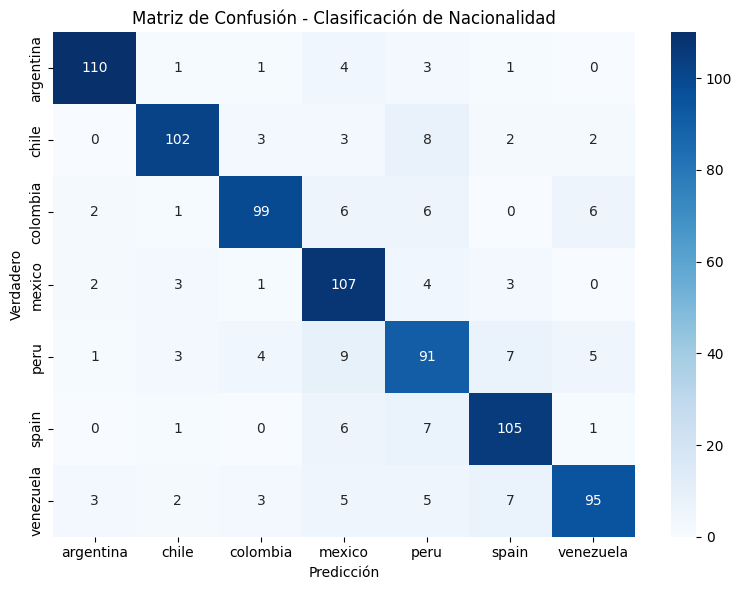

In [25]:
true_idx = label_encoder.transform(true_labels)
pred_idx = label_encoder.transform(pred_labels)
labels = label_encoder.classes_

cm = confusion_matrix(true_idx, pred_idx)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - Clasificación de Nacionalidad")
plt.tight_layout()
plt.show()


# 3.
Discuta brevemente el rendimiento del modelo anterior. Para el punto anterior, construya algunas visualizaciones como en la Figura 6 del paper de atención jerárquica y discuta.

Se escoge una predicción random para este ejemplo

In [ ]:
idx = int(random.choice(range(len(val_dataset))))
user_id = val_dataset.user_ids[idx]
true_label = label_encoder.inverse_transform([val_dataset.labels[idx]])[0]

doc = val_texts[user_id]
word_ids = [[vocab.get(word, vocab["<UNK>"]) for word in sent] for sent in doc]
tensor_doc = [torch.tensor(sent, dtype=torch.long) for sent in word_ids]

max_words = max(len(sent) for sent in tensor_doc)
padded_sents = [F.pad(sent, (0, max_words - len(sent)), value=0) for sent in tensor_doc]
padded_doc = torch.stack(padded_sents).unsqueeze(0).to(device)  

In [34]:
with torch.no_grad():
    logits, (word_att, sent_att) = model(padded_doc, return_attention=True)
    pred_label = label_encoder.inverse_transform([logits.argmax(dim=1).item()])[0]

In [35]:
from IPython.display import display, HTML

def visualize_attention(user_id, val_texts, true_label, pred_label, word_att_weights, sent_att_weights):
    sents = val_texts[user_id]
    word_weights = word_att_weights.detach().cpu().numpy()
    sent_weights = sent_att_weights.detach().cpu().numpy()

    html = f"<div style='font-family: sans-serif;'>"
    html += f"<div><b>🟢 GT:</b> {true_label} &nbsp;&nbsp; <b>🔮 Predicción:</b> {pred_label}</div><br>"

    for i, (words, sent_w) in enumerate(zip(sents, sent_weights[0])):
        if i >= len(word_weights):
            continue

        bg_color = f"rgba(255, 255, 150, {min(sent_w*1.5, 0.9):.2f})"

        html += f"<div style='background-color: {bg_color}; padding: 5px; margin-bottom: 4px; border-radius: 5px;'>"

        for j, word in enumerate(words):
            if j >= len(word_weights[i]):
                continue

            w_att = word_weights[i][j]
            word_color = f"rgba(0, 120, 255, {min(w_att*1.2, 1):.2f})"

            html += f"<span style='background-color: {word_color}; color: white; padding: 3px 5px; margin-right: 4px; border-radius: 4px;'>{word}</span>"

        html += "</div><br>"

    html += "</div>"
    display(HTML(html))


In [36]:
visualize_attention(user_id, val_texts, true_label, pred_label, word_att, sent_att)

# 5
para esta tarea: haga una comparación que muestre si la atención en jerarquía es util vs no tenerla (e.g., sin atención o tener un solo nivel de atención)

In [ ]:
class HAN_NoA(nn.Module):
    def __init__(self, embedding_matrix, word_hidden=50, sent_hidden=50, num_classes=4):
        super().__init__()
        vocab_size, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=False)

        self.word_gru = nn.GRU(emb_dim, word_hidden, batch_first=True, bidirectional=True)
        self.sent_gru = nn.GRU(word_hidden * 2, sent_hidden, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(sent_hidden * 2, num_classes)

    def forward(self, docs, sent_lens=None):
        batch_size, num_sents, num_words = docs.size()
        docs = docs.view(-1, num_words)
        x = self.embedding(docs)
        word_output, _ = self.word_gru(x)
        sent_vecs = torch.mean(word_output, dim=1)  

        sent_vecs = sent_vecs.view(batch_size, num_sents, -1)
        sent_output, _ = self.sent_gru(sent_vecs)
        doc_vecs = torch.mean(sent_output, dim=1)  

        return self.classifier(doc_vecs), None


In [ ]:
device = torch.device("cpu") 
model2 = HAN_NoA(embedding_matrix, num_classes=len(label_encoder.classes_))
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
criterion = torch.nn.NLLLoss()

In [ ]:
epochs = 5
best_val_f1 = 0
patience = 5           
epochs_without_improve = 0

In [45]:
best_val_f1 = 0
best_val_f1 = 0
for epoch in range(epochs):
    for data in tqdm(train_loader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        seq, seq_len, labels, _ = data
        seq, labels = seq.to(device), labels.to(device)
        output, _ = model2(seq, seq_len)
        output = F.log_softmax(output, dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_f1= eval_model(model2, train_loader, criterion, device)
    val_loss, val_f1 = eval_model(model2, val_loader, criterion, device)
    print('epoch: %d'%(epoch))
    print('train_loss: %5f | val_loss: %5f | train_f1: %5f | val_f1: %5f'%(train_loss, val_loss, train_f1, val_f1))
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model2.state_dict(), "best_model_han_sin.pth")
        print("Modelo mejorado guardado.")
        epochs_without_improve = 0  # Resetea el contador
    else:
        epochs_without_improve += 1
        print(f"Sin mejora en F1. {epochs_without_improve}/{patience} intentos.")

        if epochs_without_improve >= patience:
            print("No hubo mejora en las últimas épocas.")
            break

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 0
train_loss: 1.749504 | val_loss: 1.776935 | train_f1: 0.267728 | val_f1: 0.257590
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 1
train_loss: 1.113058 | val_loss: 1.256349 | train_f1: 0.543683 | val_f1: 0.483015
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.749720 | val_loss: 1.050016 | train_f1: 0.739991 | val_f1: 0.557959
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.522343 | val_loss: 1.025740 | train_f1: 0.859417 | val_f1: 0.614611
Modelo mejorado guardado.


  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.325058 | val_loss: 1.086337 | train_f1: 0.906327 | val_f1: 0.651991
Modelo mejorado guardado.


In [46]:
model2.load_state_dict(torch.load("best_model_han_sin.pth", map_location=device))
model2.to(device)
model2.eval()

/var/folders/3r/fzd1rrd908j_nt0tr8b5tkfh0000gn/T/ipykernel_56520/2931031488.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("best_model

HAN_NoAttention(
  (embedding): Embedding(973266, 100)
  (word_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (sent_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=100, out_features=7, bias=True)
)

In [69]:
val_loss2, val_f12 = eval_model(model2, val_loader, criterion, device)
print(f"Evaluación final en validación:")
print(f"Loss: {val_loss2:.4f} | F1 Score: {val_f12:.4f}")

  0%|          | 0/105 [00:00<?, ?it/s]

Evaluación final en validación:
Loss: 1.0863 | F1 Score: 0.6520
